In [1]:
import pandas as pd
import numpy as np
from numpy.random import default_rng
from matplotlib import pyplot as plt


# Introduction
This notebook explores the classic percolation model for bushfire modelling and considers the Poisson distribution later.

In [2]:
def create_lattice(p, N, mode):
    rng = default_rng()
        
    if mode == 'bernoulli':
        x = rng.uniform(low=0, high=1, size=(N, N))
        y = x < p
    elif mode == 'poisson':
        y = rng.poisson(lam=p, size=(N, N))
    return y.astype(int)

# check if node contains fuel
def burnable(node, lattice):
    return lattice[node] > 0

# returns false if index is outside of lattice
def in_lattice(index, lattice):
    m, n = lattice.shape
    i, j = index
    if not 0 <= i <= m-1 or not 0 <= j <= n-1:
        return False
    else:
        return True

def get_neighbours(node, lattice):
    # get neighbours based on reach, i.e. node value
    # same for bernoulli and poisson modes, reach = L_inf distance
    nbs = []
    i, j = node
    reach = lattice[node]
#     k + l <= reach
    for k in range(reach + 1):
        for l in range(reach + 1 - k):
            for signk in [-1, 1]:
                for signl in [-1, 1]:
                    nb = (i + signk*k, j + signl* l)
                    if in_lattice(nb, lattice):
                        nbs.append(nb)
            
    # remove duplicates from k=0 or l=0
    nbs = list(set(nbs))
    # remove original node, case k=l=0
    if node in nbs:
        nbs.remove(node)
    return nbs
    
    

In [3]:
def simulate(p, N, mode):
    # initialize
    lattice = create_lattice(p, N, mode)
    matrices = [np.copy(lattice)]
    
    front = []
    archive = []
    
    # add burnable nodes in top row to front
    I, J = np.where(lattice[:1] > 0)
    for index in zip(I, J):
        front.append(index)
        
    # spread fire until front is emtpy
    while front:
        new_front = []
        
        for node in front:
            # get neighbours before burning
            nbs = get_neighbours(node, lattice)
            lattice[node] = -1
            
            # add burnable neighbours to new front
            for nb in nbs:
                if not nb in front and not nb in archive and burnable(nb, lattice):
                    new_front.append(nb)
        
        # update archive
        archive = archive + front
        # update front
        front = new_front
        
        # save snapshot of current lattice
        mat = np.copy(lattice)
        matrices.append(mat)
        
    return matrices

In [4]:
mats = simulate(.5, 30, 'bernoulli')

# Plotting and Animating

## Create Custom Color Map

### Bernoulli

In [5]:
mats_bernoulli = simulate(0.5, 30, 'bernoulli')

In [6]:
from matplotlib import cm
from matplotlib import colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [7]:
red = np.array([colors.to_rgba('firebrick')])
brown = np.array([colors.to_rgba('orange')])
greens = cm.get_cmap('Greens', 256)



In [8]:
newcolors_bernoulli = greens(np.linspace(0, 1, 256))
newcolors_bernoulli[:25, :] = red
newcolors_bernoulli[25:129, :] = brown
newcmp_bernoulli = ListedColormap(newcolors_bernoulli)

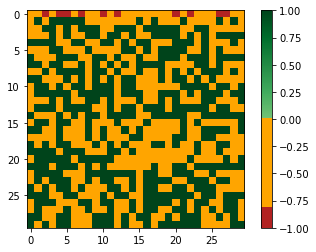

In [9]:
plt.imshow(mats_bernoulli[1], cmap = newcmp_bernoulli, vmin = -1)
plt.colorbar()

### Poisson

In [10]:
mats_poisson = simulate(0.5, 30, 'poisson')

### Segmented colormap

In [11]:
colors = ["red", "orange", "lightgreen", "darkgreen"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

In [12]:
nodes = [0.0, 0.1, 0.2, 1.0]
newcmap_poisson = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))


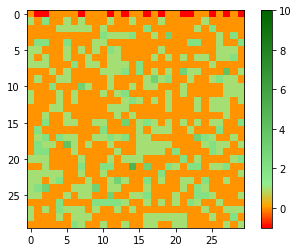

In [13]:
plt.imshow(mats_poisson[1], cmap = newcmap_poisson, vmin = -1, vmax = 10)
plt.colorbar()

# Create Animation

In [14]:
from matplotlib.animation import FuncAnimation

In [15]:
import matplotlib.animation as animation
from IPython import display

In [16]:
def animate(mats, mode):
    
    if mode == 'bernoulli':
        cmap = newcmp_bernoulli
    elif mode == 'poisson':
        cmap  = newcmap_poisson
    ims = []
    fig, ax = plt.subplots()
    
    if mode == 'bernoulli':
        for i, mat in enumerate(mats):
            im = plt.imshow(mat, cmap = cmap, vmin = -1, animated=True)

            if i==0:
                im = plt.imshow(mat, cmap = cmap, vmin = -1, animated=True)
                plt.colorbar()
            ims.append([im])
            
    elif mode == 'poisson':
        for i, mat in enumerate(mats):
            im = plt.imshow(mat, cmap = cmap, vmin = -1,
                            vmax=10, animated=True)

            if i==0:
                im = plt.imshow(mat, cmap = cmap, vmin = -1,
                                vmax=10, animated=True)
                plt.colorbar()
            ims.append([im])

    anim = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                    repeat_delay=1000)
    plt.close()
    
#     ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
#                                repeat_delay=1000)
    video = anim.to_html5_video()
    html = display.HTML(video)
    display.display(html)

In [17]:
size = 50
mats10 = simulate(0.1, size, 'bernoulli')
mats20 = simulate(0.2, size, 'bernoulli')
mats40 = simulate(0.4, size, 'bernoulli')
mats60 = simulate(0.6, size, 'bernoulli')
mats80 = simulate(0.8, size, 'bernoulli')

animate(mats10, 'bernoulli')
animate(mats20, 'bernoulli')
animate(mats40, 'bernoulli')
animate(mats60, 'bernoulli')
animate(mats80, 'bernoulli')

In [18]:
size = 50
mats10 = simulate(0.1, size, 'poisson')
mats20 = simulate(0.2, size, 'poisson')
mats40 = simulate(0.4, size, 'poisson')
mats60 = simulate(0.6, size, 'poisson')
mats80 = simulate(0.8, size, 'poisson')
mats80 = simulate(1, size, 'poisson')


animate(mats10, 'poisson')
animate(mats20, 'poisson')
animate(mats40, 'poisson')
animate(mats60, 'poisson')
animate(mats80, 'poisson')

# Data Analysis 

For site percolation we want to know how likely a fire is to reach the bottom side depending on p for Bernoulli, or lambda for Poisson.

In [108]:
def reached_bottom(mat):
    fires = mat[-1:] == -1
    return fires.any()

def get_data(p, N, iterations, mode):
    df = pd.DataFrame([], columns=['p', 'crossing', 'mode'])
    for p in P:
        for i in range(iterations):
            mats = simulate(p, N, mode)
            new_row = {'p':p, 'crossing':reached_bottom(mats[-1]), 'mode':mode}
            df = df.append(new_row, ignore_index=True)
    return df

## Bernoulli

In [113]:
iterations = 20
N = 30
P = np.linspace(0.1, 1, 20)
mode = 'bernoulli'
df = pd.DataFrame([], columns=['p', 'crossing', 'mode'])

df = get_data(p, N, iterations, mode)

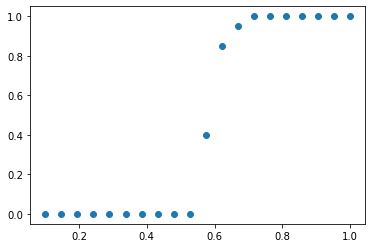

In [114]:
averages = df[['p', 'crossing']].groupby('p').mean()

averages['p'] = averages.index

plt.subplots()
plt.scatter('p', 'crossing', data=averages)

## Poisson

In [ ]:
iterations = 20
N = 30
P = np.linspace(0.1, 1, 20)
mode = 'poisson'
df = pd.DataFrame([], columns=['p', 'crossing', 'mode'])

df = get_data(p, N, iterations, mode)